# A simple polynomial regression problem

First, let us illustrate the behavihor of the Horseshoe prior solution when trying to solve a simple problem: a polunomial regression. This will be useful as a first step before moving to a more specific application: image compression.

In [1]:
import numpy as np
from Horseshoe_poly_reg import Horseshoe_poly_reg
import matplotlib.pyplot as plt
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Create a sparse polynomial regression problem

The problem is the following:  

$y = \sum_{i=0}^d \alpha_i X^i + \epsilon_i$ with $\epsilon_i \sim \mathcal{N}(0, \sigma)$, $\sigma$ fixed.  

Let us focus to the case were the vector $\alpha$ is chosen to be sparse.

In [2]:
seed = 42
ssh = Horseshoe_poly_reg()

In [3]:
X_ob, y_ob, X, y = ssh.create_poly_reg_problem(sparse=True, dim=14, sigma=2, random_state=seed) # alpha sparse, degree of polynomial up to 13

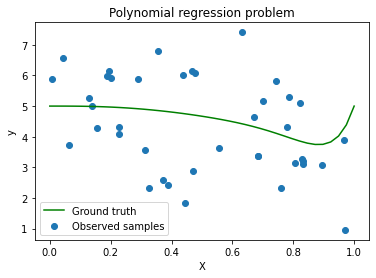

In [4]:
plt.title("Polynomial regression problem")
plt.scatter(X_ob, y_ob, label="Observed samples")
plt.plot(X, y, color="green", label="Ground truth")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

Let us look at the coefficients alpha:

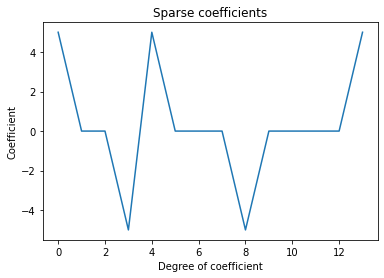

In [5]:
plt.title("Sparse coefficients")
plt.plot(ssh.coefs)
plt.xlabel("Degree of coefficient")
plt.ylabel("Coefficient")
plt.show()

### Solve the polynomial regression problem

First, let us apply a change of representation to `X_ob` and `X` to make the problem solvable through linear regression:

In [6]:
X_ob_poly = np.array([np.array([X_i**deg for deg in range(12)])for X_i in X_ob])
X_poly = np.array([np.array([X_i**deg for deg in range(12)])for X_i in X])

Now, let us solve the problem.

#### 1. Via a plain linear regression

In [7]:
from sklearn.metrics import mean_squared_error as mse

In [8]:
from sklearn.linear_model import LinearRegression

Plain linear regression

In [9]:
reg = LinearRegression(fit_intercept=False).fit(X_ob_poly, y_ob)

Result:

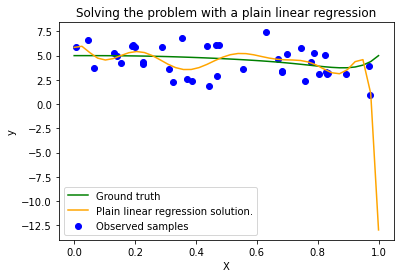

MSE vith respect to the ground truth: 8.669964


In [10]:
plt.title("Solving the problem with a plain linear regression")
plt.scatter(X_ob, y_ob, color="blue", label="Observed samples")
plt.plot(X, y, color="green", label="Ground truth")
y_out_lin = reg.predict(X_poly)
plt.plot(X, y_out_lin, color="orange", label=f"Plain linear regression solution.")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()
print(f"MSE vith respect to the ground truth: {str(mse(y_out_lin, y))[:8]}")

As expected, the plain linear regression overfits.  
Let us look at the coefficients obtained with this regression method:  

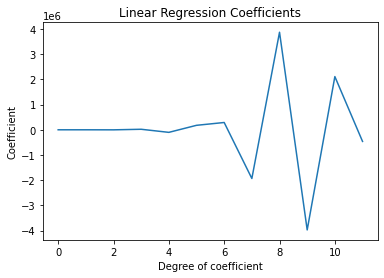

In [11]:
plt.title("Linear Regression Coefficients")
plt.plot(reg.coef_)
plt.xlabel("Degree of coefficient")
plt.ylabel("Coefficient")
plt.show()

There is some sparsity in the solution, but coefficients of highest degrees tend to explode.

#### 2. Via Ridge Regression

In [12]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In order to find a good regularization parameter, let us use a grid search.

In [13]:
regularization_params = {"alpha":np.linspace(0, 1000, 500)}

In [14]:
ridge_reg = LinearRegression(fit_intercept=False).fit(X_ob_poly, y_ob)

In [15]:
GS_RR = GridSearchCV(Ridge(), regularization_params)
GS_RR.fit(X_ob_poly, y_ob)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': array([   0.        ,    2.00400802,    4.00801603,    6.01202405,
          8.01603206,   10.02004008,   12.0240481 ,   14.02805611,
         16.03206413,   18.03607214,   20.04008016,   22.04408818,
         24.04809619,   26.05210421,   28.05611222,   30.06012024,
         32.06412826,   34.06813627,   36.07214429,   38.0761523 ,
         40.08016032,   42.08416834,   44.08817635,   46.09218437,
         48.09619238,   50.1002...
        945.89178357,  947.89579158,  949.8997996 ,  951.90380762,
        953.90781563,  955.91182365,  957.91583166,  959.91983968,
        961.9238477 ,  963.92785571,  965.93186373,  967.93587174,
        969.93987976,  971.94388778,  973.94789579,  975.95190381,
        977.95591182,  979.95991984,  981.96392786,  983.96793587,
        985.97194389,  987.9759519 ,  989.97995992,  991.98396794,
        993.98797595,  995.99198397,  997.99599198, 1000.        ])})

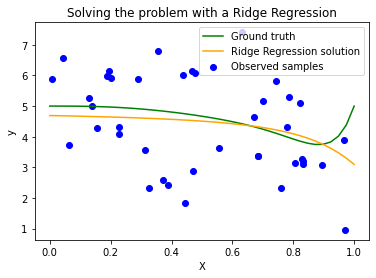

MSE vith respect to the ground truth: 0.176167


In [16]:
plt.title("Solving the problem with a Ridge Regression")
plt.scatter(X_ob, y_ob, color="blue", label="Observed samples")
plt.plot(X, y, color="green", label="Ground truth")
y_out_GS_RR = GS_RR.predict(X_poly)
plt.plot(X, y_out_GS_RR, color="orange", label="Ridge Regression solution")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()
print(f"MSE vith respect to the ground truth: {str(mse(y_out_GS_RR, y))[:8]}")

Much better !

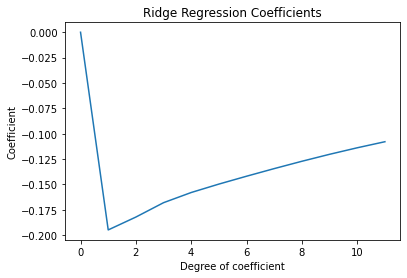

In [17]:
plt.title("Ridge Regression Coefficients")
plt.plot(GS_RR.best_estimator_.coef_)
plt.xlabel("Degree of coefficient")
plt.ylabel("Coefficient")
plt.show()

Coefficients do no explode, but the solution is not very sparse. Not many coefficient are shrinked relative to the others.

#### 2. Via the Horseshoe

In [18]:
trace = ssh.get_mcmc_sample_lin_reg(X_ob_poly, y_ob)

C:\Users\mouch\jupyter\M2_DATA\BML\project\clean\Horseshoe_poly_reg.py:73: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(samples, target_accept=.9)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Beta, tau, lambda, sigma]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 51 seconds.
There were 789 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8408511272781006, but should be close to 0.9. Try to increase the number of tuning steps.
There were 763 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1732 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5930580984244134, but should be close to 0.9. Try to increase the number of tuning steps.
There were 1149 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7489546203550708, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\mouch\anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


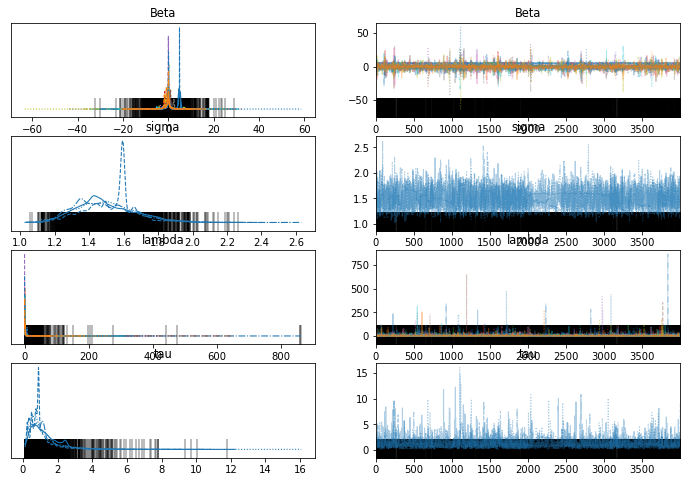

In [19]:
az.plot_trace(trace, show=True)
plt.show()

- Beta corresponds to the coefficients under study
- sigma is the standard deviation parameter of $(y | \beta) \sim \mathcal{N}(\beta, \sigma^2 I)$
- tau is the general shrinkage parameter
- lambda corresponds to local shrinkage parameters.

We can see that many $\beta_i$ are near 0. Tau is moderately close to 0 which indicate that there is some sparsity in the solution but not to much (having $\tau = 0$ would set all coefficients to 0, which one wants to avoid in most cases).  
Also note that sigma is around 1.5, which is not very far from the actual value of the problem.  
The $\lambda_i$ parameters are all quite close to 0, which is why the solution is very sparse.

In [20]:
coefs_hs = np.mean(trace.get_values("Beta"), axis=0)

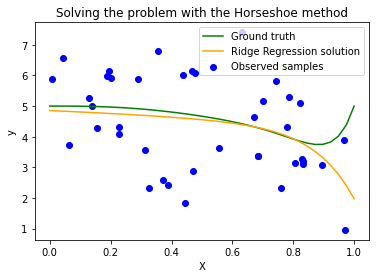

MSE vith respect to the ground truth: 0.406193


In [21]:
plt.title("Solving the problem with the Horseshoe method")
plt.scatter(X_ob, y_ob, color="blue", label="Observed samples")
plt.plot(X, y, color="green", label="Ground truth")
y_out_HS = X_poly @ coefs_hs
plt.plot(X, y_out_HS, color="orange", label="Ridge Regression solution")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()
print(f"MSE vith respect to the ground truth: {str(mse(y_out_HS, y))[:8]}")

Not as good as Ridge in terms of accuracy here (but depends on the example).

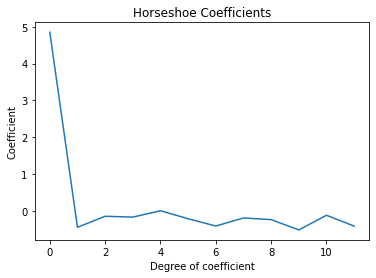

In [22]:
plt.title("Horseshoe Coefficients")
plt.plot(coefs_hs)
plt.xlabel("Degree of coefficient")
plt.ylabel("Coefficient")
plt.show()

The solution is still not sparse, since no (or not many) coefficients are equal to 0. However, the solution can be considered "pseudo-sparse" since some coefficients are shrinked.  
This solution is therefore more interesting than the ridge one if one wants to put coefficients to 0. Indeed, putting lower coefficients of the Horseshoe solution to 0 will have less impact on the result than putting lower coefficients of the Ridge solution to 0.  

Note that this example illustrate the sparsity quite well, but it really depends on example problems. Another example is described in the `README.md` file. Change the seed of the first cell to generate different problems.